In [65]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
from osgeo import gdal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import pennylane as qml
from keras.models import load_model
from keras.utils import get_custom_objects
from os.path import join
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Layer

In [23]:
class TiffImageDataGenerator(Sequence):
    def __init__(self, image_files, labels, batch_size):
        self.image_files = image_files
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        return np.array([
            self.preprocess_image(file_name) for file_name in batch_x]), np.array(batch_y)

    def preprocess_image(self, file):
        dataset = gdal.Open(file)
        channels = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
        image = np.stack(channels, axis=-1)
        image = cv2.resize(image, (64, 64))
        image = image / 255.0
        return image

dataset_path = "/home/admin1/Selvin/BE/EuroSAT_MS/"
subdirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
image_files = []
labels = []
label = 0
for subdir in subdirs:
    image_files_subdir = [os.path.join(dataset_path, subdir, f) for f in os.listdir(os.path.join(dataset_path, subdir)) if f.endswith(".tif")]
    image_files.extend(image_files_subdir)
    labels.extend([label]*len(image_files_subdir))
    label += 1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Create a TiffImageDataGenerator instance for training and testing data
train_gen = TiffImageDataGenerator(X_train, y_train, batch_size=32)
test_gen = TiffImageDataGenerator(X_test, y_test, batch_size=32)

In [5]:
class Quantum(Layer):
    def __init__(self, **kwargs):
        super(Quantum, self).__init__(**kwargs)
        self.dev = qml.device("default.qubit", wires=4)

    def build(self, input_shape):
        super(Quantum, self).build(input_shape)

    def call(self, inputs):
        # Convert inputs to tensor
        inputs = tf.convert_to_tensor(inputs)
        # Compute quantum circuit results
        output = tf.vectorized_map(self.quantum_func, inputs)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 16)

    def quantum_func(self, inputs):
        @qml.qnode(self.dev, interface='tf')
        def quantum_circuit(params):
            qml.Hadamard(wires=0)
            qml.Hadamard(wires=1)
            qml.Hadamard(wires=2)
            qml.Hadamard(wires=3)

            # Use the values in the batch item for the initial rotation (theta1)
            for i in range(4):
                qml.RY(params[i], wires=i)

            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[0, 3])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 3])

            # Use the next 4 values in the batch item for the second rotation (theta2)
            for i in range(4, 8):
                qml.RY(params[i], wires=i % 4)

            return qml.probs(wires=[0, 1, 2, 3])

        # Compute quantum circuit results
        probs = quantum_circuit(inputs)
        return probs


In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 13)))  # Assuming your images have 3 channels
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Quantum())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))  # Assuming you have 10 classes

In [8]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model using the generators
# model.fit(train_gen, validation_data=test_gen, epochs=50)

In [ ]:
# from tensorflow.keras.callbacks import LambdaCallback

# epochs = 50

# print_loss_accuracy_callback = LambdaCallback(
#     on_epoch_end=lambda epoch, logs: print(
#         f" Epoch {epoch + 1}/{epochs} - "
#         f" Training Loss: {logs['loss']:.4f}, "
#         f" Validation Loss: {logs['val_loss']:.4f}, "
#         f" Validation Accuracy: {logs['val_accuracy'] * 100:.2f}%"
#     )
# )

# # Train the model using the generators and include the callback
# model.fit(train_gen, validation_data=test_gen, epochs=epochs, callbacks=[print_loss_accuracy_callback])


In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
epochs = 50

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Define the EarlyStopping callback to stop training if there's no improvement in validation accuracy
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)

print_loss_accuracy_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f" Epoch {epoch + 1}/{epochs} - "
        f" Training Loss: {logs['loss']:.4f}, "
        f" Validation Loss: {logs['val_loss']:.4f}, "
        f" Training Accuracy: {logs['accuracy'] * 100:.2f}%, "
        f" Validation Accuracy: {logs['val_accuracy'] * 100:.2f}%"
    )
)

# Train the model using the generators and include the callbacks
history = model.fit(train_gen, validation_data=test_gen, epochs=epochs, callbacks=[print_loss_accuracy_callback, checkpoint_callback, early_stopping_callback])

# model.fit(train_gen, validation_data=test_gen, epochs=epochs, callbacks=[print_loss_accuracy_callback, checkpoint_callback])

# Load the best model based on validation accuracy
best_model = load_model("best_model.h5", custom_objects={'Quantum': Quantum})

# Save the best model with a different name, for example, "PQC_Circuit"
best_model.save("Quantum_best_model.h5")

Epoch 1/50
674/675 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9814 Epoch 1/50 -  Training Loss: 0.0653,  Validation Loss: 0.3750,  Training Accuracy: 98.13%,  Validation Accuracy: 90.59%

Epoch 1: val_accuracy improved from -inf to 0.90593, saving model to best_model.h5
675/675 [==============================] - 24s 35ms/step - loss: 0.0653 - accuracy: 0.9813 - val_loss: 0.3750 - val_accuracy: 0.9059
Epoch 2/50


/home/admin1/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


674/675 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9834 Epoch 2/50 -  Training Loss: 0.0572,  Validation Loss: 0.9886,  Training Accuracy: 98.35%,  Validation Accuracy: 81.52%

Epoch 2: val_accuracy did not improve from 0.90593
675/675 [==============================] - 24s 36ms/step - loss: 0.0572 - accuracy: 0.9835 - val_loss: 0.9886 - val_accuracy: 0.8152
Epoch 3/50
674/675 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9840 Epoch 3/50 -  Training Loss: 0.0535,  Validation Loss: 0.2100,  Training Accuracy: 98.40%,  Validation Accuracy: 95.22%

Epoch 3: val_accuracy improved from 0.90593 to 0.95222, saving model to best_model.h5
675/675 [==============================] - 25s 37ms/step - loss: 0.0535 - accuracy: 0.9840 - val_loss: 0.2100 - val_accuracy: 0.9522
Epoch 4/50
674/675 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9852 Epoch 4/50 -  Training Loss: 0.0532,  Validation Loss: 0.1820,  Training Accur

In [8]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_gen)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

NameError: name 'model' is not defined

In [11]:
predictions = model.predict(test_gen)

for i in range(len(predictions)):
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i]
    print(f"Predicted: {predicted_label}, True: {true_label}")

169/169 [==============================] - 5s 32ms/step
Predicted: 1, True: 1
Predicted: 6, True: 6
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 7, True: 7
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 9, True: 9
Predicted: 9, True: 9
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 4, True: 4
Predicted: 0, True: 0
Predicted: 4, True: 4
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 0, True: 0
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 4, True: 4
Predicted: 4, True: 4
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 2, True: 2
Predicted: 7, True: 7
Predicted: 1, True: 1
Predicted: 7, True: 7
Predicted: 4, True: 4
Predicted: 0, True: 0
Predicted: 7, True: 7
Predicted: 0, True: 

In [17]:
custom_image_path = '/home/admin1/Selvin/BE/EuroSAT_MS/River/River_1066.tif'

class_names = ['SeaLake', 'Industrial', 'HerbaceousVegetation', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'Forest', 'Highway', 'River']


dataset = gdal.Open(custom_image_path)

channels = [dataset.GetRasterBand(i+1).ReadAsArray() for i in range(dataset.RasterCount)]

image = np.stack(channels, axis=-1)

image = cv2.resize(image, (64, 64))

image = image/ 255.0

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_label = np.argmax(predictions)

predicted_class_name = class_names[predicted_label]

# Print the predicted label
print("Predicted Label:", predicted_class_name)

1/1 [==============================] - 1s 723ms/step
Predicted Label: River


In [7]:
# tf.keras.utils.plot_model(loaded_model, show_shapes=True)

# Loaded_Model Testing

In [11]:
from keras.models import load_model

# Load the saved model

In [12]:
get_custom_objects().update({'Quantum': Quantum})
loaded_model = load_model('Quantum_best_model.h5')

In [13]:
from sklearn.metrics import classification_report

y_pred = loaded_model.predict(test_gen)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

169/169 [==============================] - 6s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       595
           1       0.97      0.97      0.97       499
           2       0.94      0.97      0.96       616
           3       0.96      0.91      0.93       503
           4       0.94      0.96      0.95       598
           5       0.97      0.99      0.98       612
           6       0.89      0.97      0.93       383
           7       0.98      0.99      0.99       582
           8       0.99      0.89      0.94       507
           9       0.98      0.95      0.97       505

    accuracy                           0.96      5400
   macro avg       0.96      0.96      0.96      5400
weighted avg       0.96      0.96      0.96      5400



In [14]:
custom_image_path = '/home/admin1/Selvin/BE/EuroSAT_MS/River/River_1066.tif'

class_names = ['SeaLake', 'Industrial', 'HerbaceousVegetation', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'Forest', 'Highway', 'River']


dataset = gdal.Open(custom_image_path)

channels = [dataset.GetRasterBand(i+1).ReadAsArray() for i in range(dataset.RasterCount)]

image = np.stack(channels, axis=-1)

image = cv2.resize(image, (64, 64))

image = image/ 255.0

image = np.expand_dims(image, axis=0)

predictions = loaded_model.predict(image)

predicted_label = np.argmax(predictions)

predicted_class_name = class_names[predicted_label]

# Print the predicted label
print("Predicted Label:", predicted_class_name)

1/1 [==============================] - 1s 561ms/step
Predicted Label: River


In [15]:
predictions = loaded_model.predict(test_gen)

for i in range(len(predictions)):
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i]
    print(f"Predicted: {predicted_label}, True: {true_label}")

169/169 [==============================] - 6s 34ms/step
Predicted: 1, True: 1
Predicted: 6, True: 6
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 7, True: 7
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 9, True: 9
Predicted: 9, True: 9
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 4, True: 4
Predicted: 0, True: 0
Predicted: 4, True: 4
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 0, True: 0
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 4, True: 4
Predicted: 4, True: 4
Predicted: 7, True: 7
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 2, True: 2
Predicted: 7, True: 7
Predicted: 1, True: 1
Predicted: 7, True: 7
Predicted: 4, True: 4
Predicted: 0, True: 0
Predicted: 7, True: 7
Predicted: 0, True: 

# Visualisation

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

Confusion Matrix

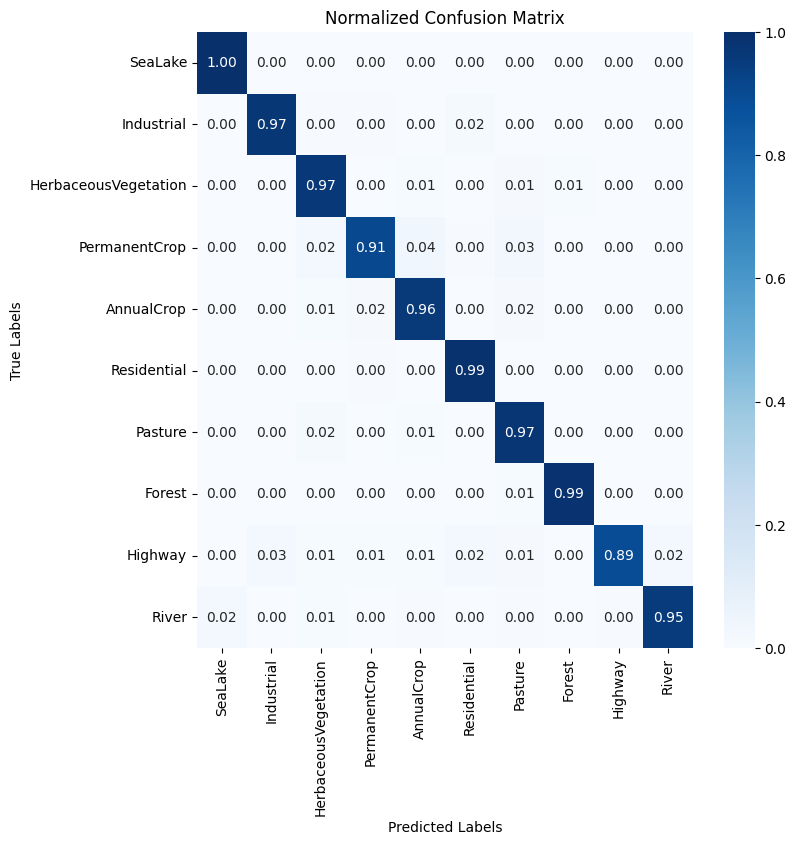

In [61]:
y_pred = np.argmax(y_prob, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix with annotations
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('normalized_confusion_matrix.jpg', format='jpeg', bbox_inches='tight')
plt.show()


Precision-Recall Curve

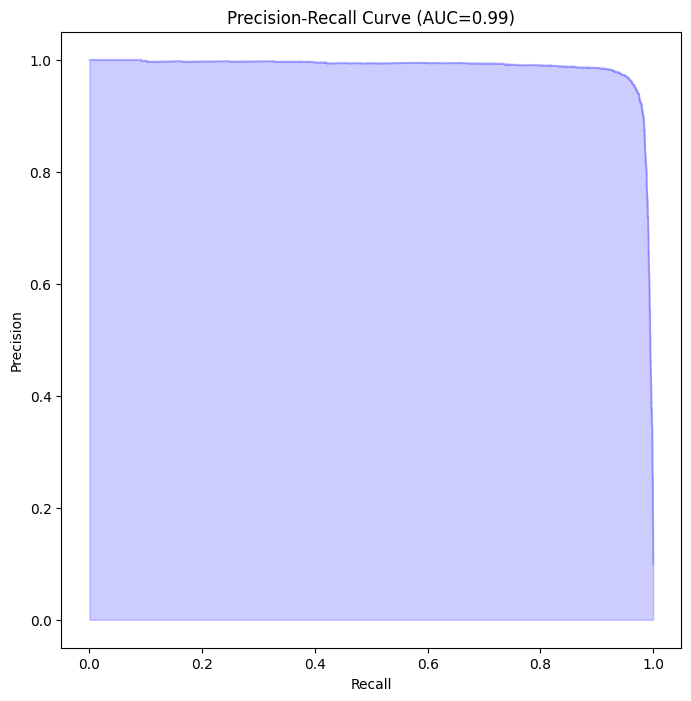

In [62]:
y_test_one_hot = label_binarize(y_test, classes=range(10))  # Assuming 10 classes

precision, recall, _ = precision_recall_curve(y_test_one_hot.ravel(), y_prob.ravel())
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={area_under_curve:.2f})')
plt.savefig('Precision_Recall.jpg', format='jpeg', bbox_inches='tight')
plt.show()

1/1 [==============================] - 0s 23ms/step


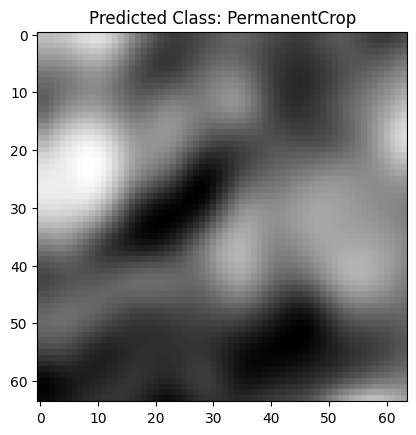

In [63]:
image_path = '/home/admin1/Selvin/BE/EuroSAT_MS/PermanentCrop/PermanentCrop_1066.tif'
specific_image = np.array([TiffImageDataGenerator([image_path], [0], batch_size=1).preprocess_image(image_path)])

# Predict the class for the specific image
predicted_class_number = np.argmax(loaded_model.predict(specific_image))
predicted_class_name = class_names[predicted_class_number]
# Display the image and information
plt.figure()
plt.imshow(specific_image[0][:, :, 0], cmap='gray')  # Assuming you want to visualize the first channel
plt.title(f"Predicted Class: {predicted_class_name}")
plt.savefig('Predictions.jpg', format='jpeg', bbox_inches='tight')
plt.show()

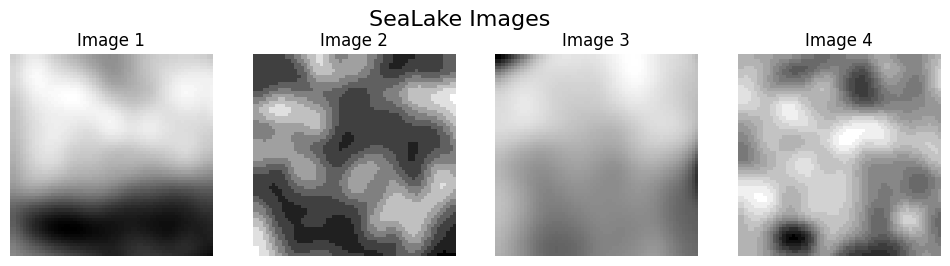

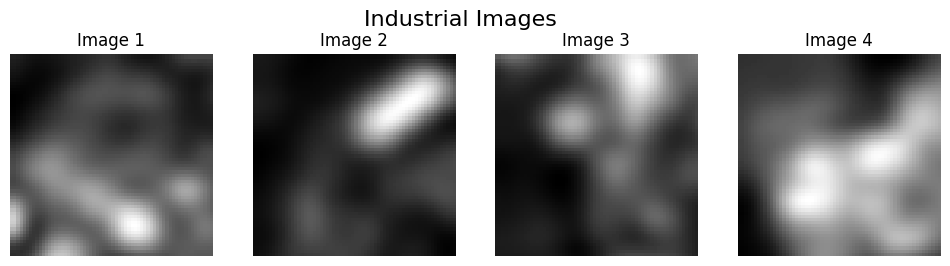

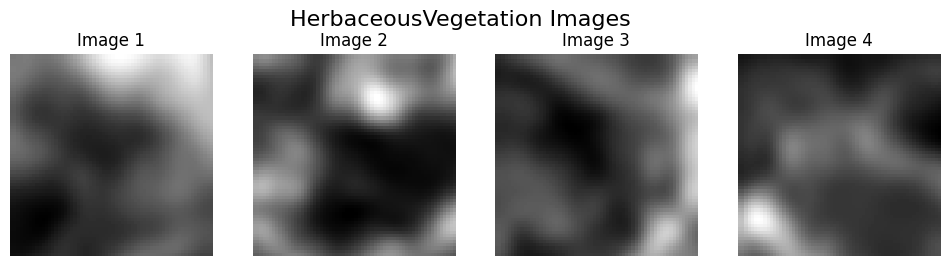

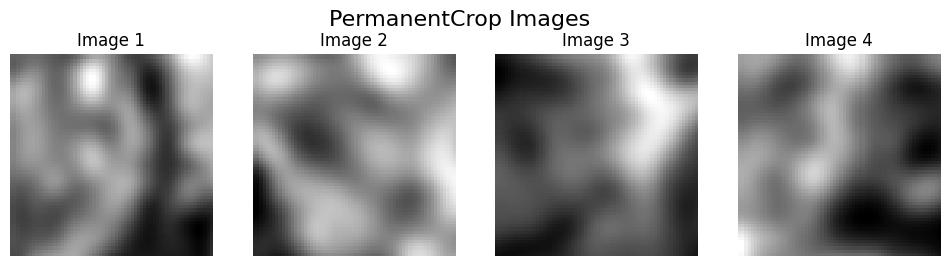

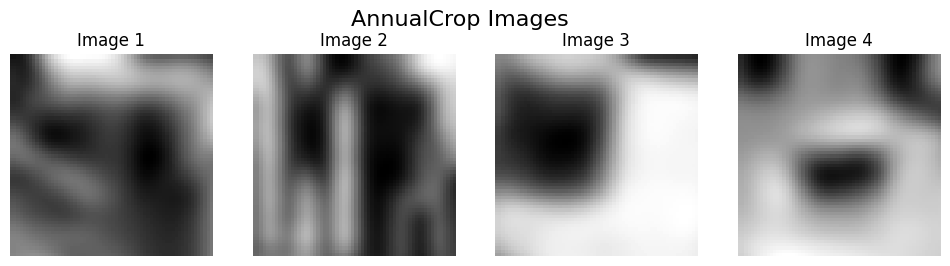

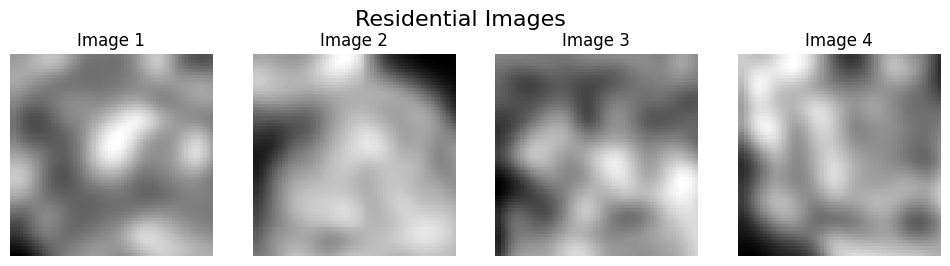

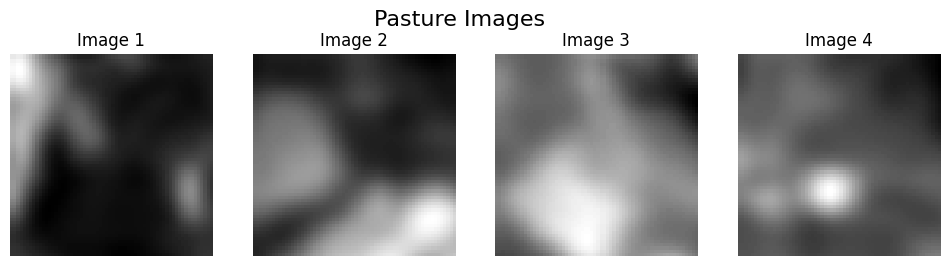

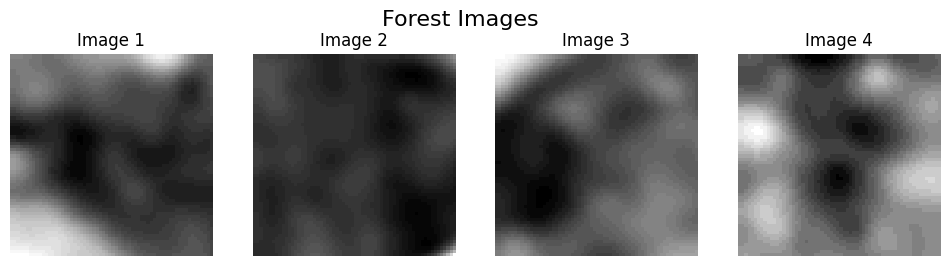

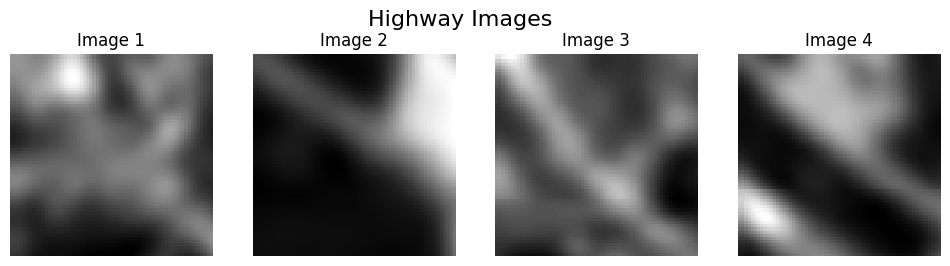

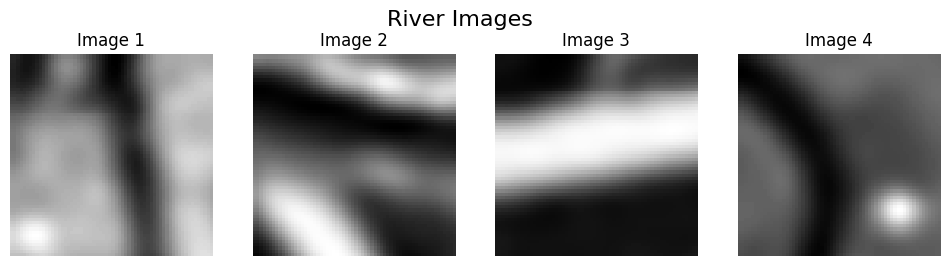

In [69]:
# def load_tiff_image(file_path):
#     try:
#         dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
#         if dataset is None:
#             raise Exception(f"Error opening TIFF image: {file_path}")
        
#         # Read the image data
#         image_data = dataset.ReadAsArray()

#         return image_data
#     except Exception as e:
#         print(f"Error loading TIFF image: {e}")
#         return None

# def display_class_images(dataset_path, class_name, num_images=4):
#     class_path = os.path.join(dataset_path, class_name)
#     image_files = [f for f in os.listdir(class_path) if f.endswith(".tif")]

#     plt.figure(figsize=(12, 3))
#     plt.suptitle(f'{class_name} Images', fontsize=16)

#     for i, image_file in enumerate(image_files[:num_images]):
#         image_path = os.path.join(class_path, image_file)
#         image_data = load_tiff_image(image_path)

#         if image_data is not None:
#             plt.subplot(1, num_images, i + 1)
#             plt.imshow(image_data[0, :, :], cmap='gray')  # Assuming grayscale
#             plt.title(f"Image {i + 1}")
#             plt.axis('off')
#         else:
#             print(f"Failed to load image: {image_file}")

#     plt.show()

# # Example usage
# dataset_path = "/home/admin1/Selvin/BE/EuroSAT_MS/"
# class_names = ['SeaLake', 'Industrial', 'HerbaceousVegetation', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'Forest', 'Highway', 'River']

# for class_name in class_names:
#     display_class_images(dataset_path, class_name)



def load_tiff_image(file_path):
    try:
        dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
        if dataset is None:
            raise Exception(f"Error opening TIFF image: {file_path}")
        
        # Read the image data
        image_data = dataset.ReadAsArray()

        return image_data
    except Exception as e:
        print(f"Error loading TIFF image: {e}")
        return None

def display_class_images(dataset_path, class_name, num_images=4, save_path=None):
    class_path = join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(".tif")]

    plt.figure(figsize=(12, 3))
    plt.suptitle(f'{class_name} Images', fontsize=16)

    for i, image_file in enumerate(image_files[:num_images]):
        image_path = join(class_path, image_file)
        image_data = load_tiff_image(image_path)

        if image_data is not None:
            # Display the image
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image_data[0, :, :], cmap='gray')  # Assuming grayscale
            plt.title(f"Image {i + 1}")
            plt.axis('off')

            # Save the image
            if save_path is not None:
                image_name = f"{class_name}_Image_{i + 1}.png"
                image_save_path = join(save_path, image_name)
                plt.savefig(image_save_path, format='png', bbox_inches='tight')
        else:
            print(f"Failed to load image: {image_file}")

    plt.show()

# Example usage
dataset_path = "/home/admin1/Selvin/BE/EuroSAT_MS/"
class_names = ['SeaLake', 'Industrial', 'HerbaceousVegetation', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'Forest', 'Highway', 'River']

save_path = "/home/admin1/Selvin/BE/FINAL/MY/TIFF"  # Replace with your desired save path

# Ensure the directory exists, create it if it doesn't
os.makedirs(save_path, exist_ok=True)

for class_name in class_names:
    display_class_images(dataset_path, class_name, num_images=4, save_path=save_path)